CELL 1 — Mount Drive + paths

In [1]:
import os
from pathlib import Path

from google.colab import drive
drive.mount("/content/drive")

DATASET_DIR = "/content/drive/MyDrive/Segmentation GP/Kaggle_Dataset"
OUT_DIR = "/content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

print("DATASET_DIR:", DATASET_DIR)
print("OUT_DIR:", OUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATASET_DIR: /content/drive/MyDrive/Segmentation GP/Kaggle_Dataset
OUT_DIR: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2


CELL 2 — Install deps

In [2]:
!pip -q uninstall -y pillow
!pip -q install --no-cache-dir "pillow<12"
!pip -q install -U transformers accelerate timm opencv-python matplotlib tqdm torchmetrics scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 63.6 MB/s eta 0:00:00


CELL 3 — Imports + device

In [3]:
import json, random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from pathlib import Path

from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation, Mask2FormerForUniversalSegmentation

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cuda


CELL 4 — Build image list (flat root images)

In [4]:
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp",".png"}

root = Path(DATASET_DIR)
img_files = sorted([p for p in root.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS])

print("Images:", len(img_files))
assert len(img_files) > 0, "No images found in dataset root."
print("Sample:", img_files[0].name)


Images: 563
Sample: 0_00030.png


CELL 5 — Teacher pseudo-labels (ADE150 semantic IDs)

In [5]:
TEACHER_ID = "facebook/mask2former-swin-small-ade-semantic"  # T4-safe
teacher_processor = AutoImageProcessor.from_pretrained(TEACHER_ID)
teacher = Mask2FormerForUniversalSegmentation.from_pretrained(TEACHER_ID).to(device).eval()

pseudo_dir = Path(OUT_DIR) / "pseudo_ade150"
pseudo_dir.mkdir(parents=True, exist_ok=True)

@torch.no_grad()
def teacher_predict_sem_id(pil_img: Image.Image, resize_max=1024):
    w, h = pil_img.size
    scale = min(1.0, resize_max / max(w, h))
    if scale < 1.0:
        pil_small = pil_img.resize((int(w*scale), int(h*scale)), Image.BILINEAR)
    else:
        pil_small = pil_img

    inputs = teacher_processor(images=pil_small, return_tensors="pt").to(device)
    with torch.amp.autocast('cuda', enabled=(device=="cuda")):
        outputs = teacher(**inputs)

    sem = teacher_processor.post_process_semantic_segmentation(
        outputs, target_sizes=[pil_small.size[::-1]]
    )[0]
    sem_id = sem.detach().cpu().numpy().astype(np.uint8)

    if scale < 1.0:
        sem_id = cv2.resize(sem_id, (w, h), interpolation=cv2.INTER_NEAREST)

    return sem_id

existing = list(pseudo_dir.glob("*.png"))
if len(existing) == len(img_files):
    print("✅ Pseudo labels already exist:", len(existing))
else:
    for ip in tqdm(img_files, desc="Generating ADE150 pseudo-labels"):
        pil = Image.open(ip).convert("RGB")
        sem_id = teacher_predict_sem_id(pil, resize_max=1024)
        cv2.imwrite(str(pseudo_dir / f"{ip.stem}.png"), sem_id)
    print("✅ Done:", len(list(pseudo_dir.glob("*.png"))))

with open(Path(OUT_DIR)/"ade150_id2label.json", "w") as f:
    json.dump(teacher.config.id2label, f, indent=2)
print("Saved id2label:", Path(OUT_DIR)/"ade150_id2label.json")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The image processor of type `Mask2FormerImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/782 [00:00<?, ?it/s]

Generating ADE150 pseudo-labels: 100%|██████████| 563/563 [01:40<00:00,  5.58it/s]

✅ Done: 563
Saved id2label: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/ade150_id2label.json


CELL 6 — Collapse ADE150 → 13 “scene” classes (this fixes your “two background colors / furniture missing” expectation)

In [6]:
# We map ADE labels -> superclasses. Not perfect, but way more sane than 150 classes.
# You can extend this later.

with open(Path(OUT_DIR)/"ade150_id2label.json","r") as f:
    ade_id2label = {int(k): v for k,v in json.load(f).items()}

SUPER = [
    "background",   # 0
    "person",       # 1
    "floor",        # 2
    "wall",         # 3
    "ceiling",      # 4
    "road/sidewalk",# 5
    "building",     # 6
    "furniture",    # 7
    "window/door",  # 8
    "vegetation",   # 9
    "sky",          # 10
    "water",        # 11
    "other"         # 12
]
K = len(SUPER)

def label_to_super(label: str):
    s = label.lower()

    if "person" in s:
        return 1

    if any(x in s for x in ["floor", "carpet", "rug", "mat"]):
        return 2
    if any(x in s for x in ["wall"]):
        return 3
    if any(x in s for x in ["ceiling"]):
        return 4

    if any(x in s for x in ["road", "sidewalk", "path", "street"]):
        return 5

    if any(x in s for x in ["building", "house", "skyscraper"]):
        return 6

    if any(x in s for x in ["chair","sofa","couch","table","bed","cabinet","shelf","desk","wardrobe","bench","stool"]):
        return 7

    if any(x in s for x in ["window","door"]):
        return 8

    if any(x in s for x in ["tree","plant","vegetation","grass","bush"]):
        return 9

    if "sky" in s:
        return 10
    if any(x in s for x in ["water","river","sea","ocean","pool"]):
        return 11

    # 0 is reserved for background/void only if you want it.
    return 12

# build mapping array for 0..149 ADE ids
ade_to_super = np.zeros((150,), dtype=np.uint8)
for cid in range(150):
    ade_to_super[cid] = label_to_super(ade_id2label.get(cid, "other"))

# save mapping for reproducibility
np.save(Path(OUT_DIR)/"ade_to_super.npy", ade_to_super)
with open(Path(OUT_DIR)/"super_classes.json","w") as f:
    json.dump({"classes": SUPER}, f, indent=2)

print("✅ Superclasses:", SUPER)
print("✅ Saved mapping:", Path(OUT_DIR)/"ade_to_super.npy")


✅ Superclasses: ['background', 'person', 'floor', 'wall', 'ceiling', 'road/sidewalk', 'building', 'furniture', 'window/door', 'vegetation', 'sky', 'water', 'other']
✅ Saved mapping: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/ade_to_super.npy


CELL 7 — Build pairs + split train/val/test

In [7]:
pairs = []
missing = 0
for ip in img_files:
    mp = pseudo_dir / f"{ip.stem}.png"
    if mp.exists():
        pairs.append((ip, mp))
    else:
        missing += 1

print("Pairs:", len(pairs), "Missing:", missing)
assert len(pairs) > 0

random.seed(42)
random.shuffle(pairs)

n = len(pairs)
n_train = int(0.8*n)
n_val = int(0.1*n)

train_pairs = pairs[:n_train]
val_pairs = pairs[n_train:n_train+n_val]
test_pairs = pairs[n_train+n_val:]

print("Split:", len(train_pairs), len(val_pairs), len(test_pairs))


Pairs: 563 Missing: 0
Split: 450 56 57


CELL 8 — Dataset + DataLoaders (collapses labels on the fly)

In [9]:
import random, numpy as np, cv2, torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from transformers import AutoImageProcessor

# Define processor HERE so this cell doesn't depend on Cell 10.
# If you later switch to B4 instead of B5, change it here too.
STUDENT_ID = "nvidia/segformer-b5-finetuned-ade-640-640"
student_processor = AutoImageProcessor.from_pretrained(STUDENT_ID)

TRAIN_SIZE = 640     # higher detail than 512
BATCH = 1            # B5@640 is heavy; use grad_accum later
NUM_WORKERS = 2

def letterbox_pad_rgb_and_mask(img_rgb: np.ndarray, mask: np.ndarray, out_size=640):
    """
    Keep aspect ratio, resize to fit within out_size, then pad to square out_size.
    img_rgb: (H,W,3) uint8 RGB
    mask:    (H,W)   uint8 (class ids)
    """
    H, W = img_rgb.shape[:2]
    scale = min(out_size / W, out_size / H)
    newW, newH = int(round(W * scale)), int(round(H * scale))

    img_rs = cv2.resize(img_rgb, (newW, newH), interpolation=cv2.INTER_LINEAR)
    mask_rs = cv2.resize(mask, (newW, newH), interpolation=cv2.INTER_NEAREST)

    padW = out_size - newW
    padH = out_size - newH
    left = padW // 2
    right = padW - left
    top = padH // 2
    bottom = padH - top

    img_pad = cv2.copyMakeBorder(img_rs, top, bottom, left, right,
                                 cv2.BORDER_CONSTANT, value=(0,0,0))
    mask_pad = cv2.copyMakeBorder(mask_rs, top, bottom, left, right,
                                  cv2.BORDER_CONSTANT, value=0)

    return img_pad, mask_pad

class SceneDataset(Dataset):
    def __init__(self, pairs, processor, ade_to_super, out_size=640, augment=True):
        self.pairs = pairs
        self.processor = processor
        self.map = ade_to_super
        self.out_size = out_size
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, ade_mask_path = self.pairs[idx]

        pil = Image.open(img_path).convert("RGB")
        img = np.array(pil)  # (H,W,3) RGB uint8

        ade = cv2.imread(str(ade_mask_path), cv2.IMREAD_GRAYSCALE).astype(np.uint8)
        collapsed = self.map[ade]  # (H,W) uint8 in [0..K-1]

        # --- Light augmentation ---
        if self.augment and random.random() < 0.5:
            img = np.ascontiguousarray(img[:, ::-1, :])
            collapsed = np.ascontiguousarray(collapsed[:, ::-1])

        # letterbox pad to square without distortion
        img_sq, mask_sq = letterbox_pad_rgb_and_mask(img, collapsed, out_size=self.out_size)

        inputs = self.processor(images=img_sq, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3,H,W)

        labels = torch.from_numpy(mask_sq.astype(np.int64))  # (H,W) long
        return {"pixel_values": pixel_values, "labels": labels, "img_path": str(img_path)}

def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    labels = torch.stack([b["labels"] for b in batch])
    img_paths = [b["img_path"] for b in batch]
    return {"pixel_values": pixel_values, "labels": labels, "img_paths": img_paths}

train_ds = SceneDataset(train_pairs, student_processor, ade_to_super, out_size=TRAIN_SIZE, augment=True)
val_ds   = SceneDataset(val_pairs,   student_processor, ade_to_super, out_size=TRAIN_SIZE, augment=False)
test_ds  = SceneDataset(test_pairs,  student_processor, ade_to_super, out_size=TRAIN_SIZE, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)

print("✅ loaders ready | STUDENT_ID:", STUDENT_ID, "| TRAIN_SIZE:", TRAIN_SIZE, "| BATCH:", BATCH)


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

The image processor of type `SegformerImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


✅ loaders ready | STUDENT_ID: nvidia/segformer-b5-finetuned-ade-640-640 | TRAIN_SIZE: 640 | BATCH: 1


CELL 9 — Metrics helpers (mIoU, Dice, BFScore) + plot utilities

In [10]:
from torchmetrics.classification import MulticlassJaccardIndex
import numpy as np

miou_metric = MulticlassJaccardIndex(num_classes=K, average="macro").to(device)

def dice_macro(pred, gt, num_classes):
    # pred, gt: (H,W) long
    dice_scores = []
    for c in range(num_classes):
        p = (pred == c)
        g = (gt == c)
        inter = (p & g).sum().item()
        denom = p.sum().item() + g.sum().item()
        if denom == 0:
            continue
        dice_scores.append((2*inter) / (denom + 1e-9))
    return float(np.mean(dice_scores)) if len(dice_scores) else 0.0

def boundary_f1(pred, gt, radius=2):
    # very light BFScore proxy using edges
    pred_u = pred.astype(np.uint8)
    gt_u = gt.astype(np.uint8)
    pe = cv2.Canny(pred_u, 0, 1)
    ge = cv2.Canny(gt_u, 0, 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    pe_d = cv2.dilate(pe, kernel)
    ge_d = cv2.dilate(ge, kernel)

    tp = ((pe > 0) & (ge_d > 0)).sum()
    fp = ((pe > 0) & (ge_d == 0)).sum()
    fn = ((ge > 0) & (pe_d == 0)).sum()

    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1 = 2*precision*recall / (precision + recall + 1e-9)
    return float(f1)

print("✅ metrics helpers ready")


✅ metrics helpers ready


CELL 10 — Load student model (SegFormer) configured for K classes

In [11]:
from transformers import SegformerForSemanticSegmentation, AutoImageProcessor

# STUDENT_ID = "nvidia/segformer-b4-finetuned-ade-512-512"
STUDENT_ID = "nvidia/segformer-b5-finetuned-ade-640-640"

student_processor = AutoImageProcessor.from_pretrained(STUDENT_ID)

student = SegformerForSemanticSegmentation.from_pretrained(
    STUDENT_ID,
    num_labels=K,
    id2label={i: SUPER[i] for i in range(K)},
    label2id={SUPER[i]: i for i in range(K)},
    ignore_mismatched_sizes=True
).to(device)

print("✅ student ready:", STUDENT_ID, "| classes:", K)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/1172 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b5-finetuned-ade-640-640
Key                           | Status   |                                                                                                    
------------------------------+----------+----------------------------------------------------------------------------------------------------
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([150]) vs model:torch.Size([13])                      
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([150, 768, 1, 1]) vs model:torch.Size([13, 768, 1, 1])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


✅ student ready: nvidia/segformer-b5-finetuned-ade-640-640 | classes: 13


CELL 11 — Training (early stopping + best save + CSV log + curves)

epoch 1/30: 100%|██████████| 450/450 [02:45<00:00,  2.72it/s, loss=2.2]


Epoch 1 | train_loss=2.1958 | val mIoU=0.2559 | Dice=0.2943 | BF=0.2123


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 2/30: 100%|██████████| 450/450 [02:39<00:00,  2.83it/s, loss=1.31]


Epoch 2 | train_loss=1.3141 | val mIoU=0.4753 | Dice=0.5197 | BF=0.2654


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 3/30: 100%|██████████| 450/450 [02:43<00:00,  2.75it/s, loss=0.847]


Epoch 3 | train_loss=0.8465 | val mIoU=0.5526 | Dice=0.5997 | BF=0.4086


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 4/30: 100%|██████████| 450/450 [02:44<00:00,  2.73it/s, loss=0.581]


Epoch 4 | train_loss=0.5810 | val mIoU=0.5908 | Dice=0.6369 | BF=0.4876


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 5/30: 100%|██████████| 450/450 [02:46<00:00,  2.70it/s, loss=0.43]


Epoch 5 | train_loss=0.4296 | val mIoU=0.6503 | Dice=0.6899 | BF=0.6168


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 6/30: 100%|██████████| 450/450 [02:46<00:00,  2.70it/s, loss=0.328]


Epoch 6 | train_loss=0.3284 | val mIoU=0.6855 | Dice=0.7274 | BF=0.6302


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 7/30: 100%|██████████| 450/450 [02:44<00:00,  2.74it/s, loss=0.259]


Epoch 7 | train_loss=0.2593 | val mIoU=0.6829 | Dice=0.7269 | BF=0.6271


epoch 8/30: 100%|██████████| 450/450 [02:37<00:00,  2.86it/s, loss=0.223]


Epoch 8 | train_loss=0.2227 | val mIoU=0.6711 | Dice=0.7145 | BF=0.6252


epoch 9/30: 100%|██████████| 450/450 [02:58<00:00,  2.52it/s, loss=0.185]


Epoch 9 | train_loss=0.1851 | val mIoU=0.6977 | Dice=0.7402 | BF=0.6282


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 10/30: 100%|██████████| 450/450 [02:43<00:00,  2.75it/s, loss=0.156]


Epoch 10 | train_loss=0.1557 | val mIoU=0.6715 | Dice=0.7139 | BF=0.5926


epoch 11/30: 100%|██████████| 450/450 [02:38<00:00,  2.84it/s, loss=0.144]


Epoch 11 | train_loss=0.1444 | val mIoU=0.7035 | Dice=0.7477 | BF=0.6232


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 12/30: 100%|██████████| 450/450 [02:45<00:00,  2.72it/s, loss=0.123]


Epoch 12 | train_loss=0.1231 | val mIoU=0.6952 | Dice=0.7383 | BF=0.5864


epoch 13/30: 100%|██████████| 450/450 [02:38<00:00,  2.85it/s, loss=0.113]


Epoch 13 | train_loss=0.1126 | val mIoU=0.6878 | Dice=0.7302 | BF=0.6602


epoch 14/30: 100%|██████████| 450/450 [02:38<00:00,  2.84it/s, loss=0.0986]


Epoch 14 | train_loss=0.0986 | val mIoU=0.6934 | Dice=0.7371 | BF=0.6021


epoch 15/30: 100%|██████████| 450/450 [02:37<00:00,  2.86it/s, loss=0.087]


Epoch 15 | train_loss=0.0870 | val mIoU=0.6977 | Dice=0.7415 | BF=0.6411


epoch 16/30: 100%|██████████| 450/450 [02:38<00:00,  2.84it/s, loss=0.0832]


Epoch 16 | train_loss=0.0832 | val mIoU=0.6918 | Dice=0.7350 | BF=0.6360


epoch 17/30: 100%|██████████| 450/450 [02:38<00:00,  2.84it/s, loss=0.0733]


Epoch 17 | train_loss=0.0733 | val mIoU=0.7102 | Dice=0.7532 | BF=0.6832


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 18/30: 100%|██████████| 450/450 [02:44<00:00,  2.74it/s, loss=0.067]


Epoch 18 | train_loss=0.0670 | val mIoU=0.7086 | Dice=0.7544 | BF=0.6081


epoch 19/30: 100%|██████████| 450/450 [02:37<00:00,  2.87it/s, loss=0.0602]


Epoch 19 | train_loss=0.0602 | val mIoU=0.7194 | Dice=0.7638 | BF=0.6960


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 20/30: 100%|██████████| 450/450 [02:44<00:00,  2.74it/s, loss=0.0569]


Epoch 20 | train_loss=0.0569 | val mIoU=0.7041 | Dice=0.7471 | BF=0.6419


epoch 21/30: 100%|██████████| 450/450 [02:38<00:00,  2.85it/s, loss=0.0566]


Epoch 21 | train_loss=0.0566 | val mIoU=0.7157 | Dice=0.7564 | BF=0.7044


epoch 22/30: 100%|██████████| 450/450 [02:36<00:00,  2.87it/s, loss=0.0524]


Epoch 22 | train_loss=0.0524 | val mIoU=0.7025 | Dice=0.7456 | BF=0.6660


epoch 23/30: 100%|██████████| 450/450 [02:38<00:00,  2.85it/s, loss=0.048]


Epoch 23 | train_loss=0.0480 | val mIoU=0.7198 | Dice=0.7613 | BF=0.7194


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ saved best: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/best_student_b5


epoch 24/30: 100%|██████████| 450/450 [02:44<00:00,  2.74it/s, loss=0.044]


Epoch 24 | train_loss=0.0440 | val mIoU=0.7116 | Dice=0.7518 | BF=0.7202


epoch 25/30: 100%|██████████| 450/450 [02:36<00:00,  2.88it/s, loss=0.0405]


Epoch 25 | train_loss=0.0405 | val mIoU=0.7048 | Dice=0.7449 | BF=0.7096


epoch 26/30: 100%|██████████| 450/450 [02:36<00:00,  2.87it/s, loss=0.0394]


Epoch 26 | train_loss=0.0394 | val mIoU=0.7150 | Dice=0.7558 | BF=0.7152


epoch 27/30: 100%|██████████| 450/450 [02:37<00:00,  2.86it/s, loss=0.0377]


Epoch 27 | train_loss=0.0377 | val mIoU=0.7147 | Dice=0.7571 | BF=0.7139


epoch 28/30: 100%|██████████| 450/450 [02:37<00:00,  2.86it/s, loss=0.0451]


Epoch 28 | train_loss=0.0451 | val mIoU=0.7121 | Dice=0.7529 | BF=0.7097


epoch 29/30: 100%|██████████| 450/450 [02:35<00:00,  2.89it/s, loss=0.0366]


Epoch 29 | train_loss=0.0366 | val mIoU=0.7149 | Dice=0.7555 | BF=0.7233
🛑 early stop
✅ log: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/train_log_b5.csv


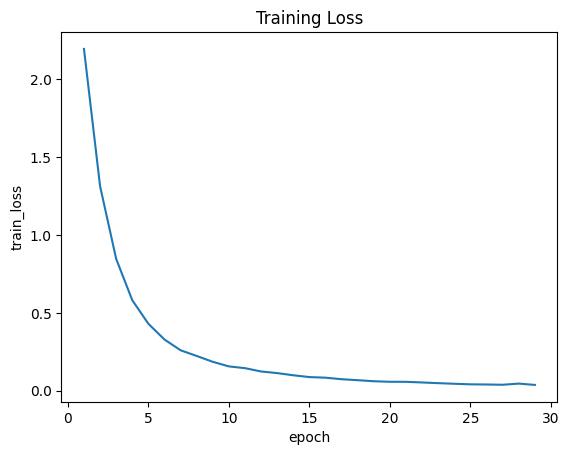

✅ saved: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/plots/train_loss.png


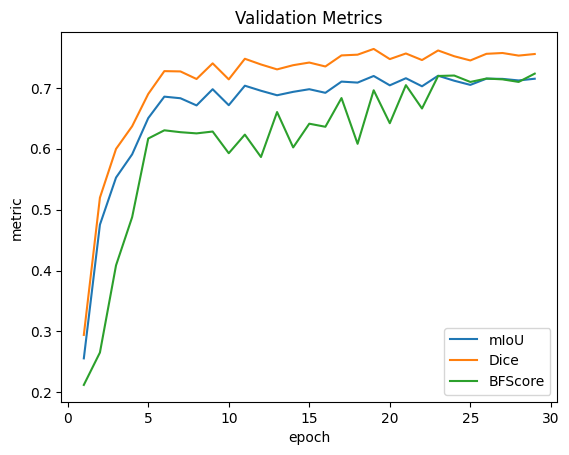

✅ saved: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/plots/val_metrics.png


In [12]:
import torch, numpy as np, pandas as pd
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

LR = 5e-5
EPOCHS = 30
PATIENCE = 6
GRAD_ACCUM = 2
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.06

optimizer = AdamW(student.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler('cuda', enabled=(device=="cuda"))

steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

best_miou = -1.0
bad = 0
log = []

best_dir = Path(OUT_DIR) / "best_student_b5"
best_dir.mkdir(parents=True, exist_ok=True)

@torch.no_grad()
def forward_pred(pixel_values, target_hw):
    with torch.amp.autocast('cuda', enabled=(device=="cuda")):
        out = student(pixel_values=pixel_values)
        logits = out.logits  # (B,K,h,w)

    logits_up = F.interpolate(logits, size=target_hw, mode="bilinear", align_corners=False)
    pred = torch.argmax(logits_up, dim=1)
    return pred

@torch.no_grad()
def evaluate(loader):
    student.eval()
    miou_vals, dice_vals, bf_vals = [], [], []

    for batch in tqdm(loader, desc="eval", leave=False):
        pv = batch["pixel_values"].to(device)
        gt = batch["labels"].to(device)  # (B,S,S)

        H, W = gt.shape[-2], gt.shape[-1]
        pred = forward_pred(pv, (H, W))

        miou_vals.append(float(miou_metric(pred, gt)))
        dice_vals.append(dice_macro(pred[0].detach().cpu(), gt[0].detach().cpu(), K))
        bf_vals.append(boundary_f1(
            pred[0].detach().cpu().numpy().astype(np.uint8),
            gt[0].detach().cpu().numpy().astype(np.uint8),
            radius=2
        ))

    return {"mIoU": float(np.mean(miou_vals)),
            "Dice": float(np.mean(dice_vals)),
            "BFScore": float(np.mean(bf_vals))}

global_step = 0

for epoch in range(1, EPOCHS+1):
    student.train()
    losses = []
    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(train_loader, desc=f"epoch {epoch}/{EPOCHS}")
    for step, batch in enumerate(pbar, start=1):
        pv = batch["pixel_values"].to(device)
        gt = batch["labels"].to(device)

        with torch.amp.autocast('cuda', enabled=(device=="cuda")):
            out = student(pixel_values=pv, labels=gt)
            loss = out.loss / GRAD_ACCUM

        scaler.scale(loss).backward()

        if step % GRAD_ACCUM == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        losses.append(float(loss.item() * GRAD_ACCUM))
        pbar.set_postfix(loss=float(np.mean(losses)))

        global_step += 1

    train_loss = float(np.mean(losses))
    val = evaluate(val_loader)

    print(f"Epoch {epoch} | train_loss={train_loss:.4f} | val mIoU={val['mIoU']:.4f} | Dice={val['Dice']:.4f} | BF={val['BFScore']:.4f}")

    log.append({"epoch": epoch, "train_loss": train_loss, **val})

    if val["mIoU"] > best_miou + 1e-4:
        best_miou = val["mIoU"]
        bad = 0
        student.save_pretrained(best_dir)
        student_processor.save_pretrained(best_dir)
        print("✅ saved best:", best_dir)
    else:
        bad += 1
        if bad >= PATIENCE:
            print("🛑 early stop")
            break

# Save log CSV
log_df = pd.DataFrame(log)
csv_path = Path(OUT_DIR) / "train_log_b5.csv"
log_df.to_csv(csv_path, index=False)
print("✅ log:", csv_path)

# Save graphs (PNG) to Drive
plot_dir = Path(OUT_DIR) / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)

plt.figure()
plt.plot(log_df["epoch"], log_df["train_loss"])
plt.xlabel("epoch"); plt.ylabel("train_loss"); plt.title("Training Loss")
loss_png = plot_dir / "train_loss.png"
plt.savefig(loss_png, dpi=200, bbox_inches="tight")
plt.show()
print("✅ saved:", loss_png)

plt.figure()
plt.plot(log_df["epoch"], log_df["mIoU"], label="mIoU")
plt.plot(log_df["epoch"], log_df["Dice"], label="Dice")
plt.plot(log_df["epoch"], log_df["BFScore"], label="BFScore")
plt.xlabel("epoch"); plt.ylabel("metric"); plt.title("Validation Metrics")
plt.legend()
met_png = plot_dir / "val_metrics.png"
plt.savefig(met_png, dpi=200, bbox_inches="tight")
plt.show()
print("✅ saved:", met_png)


CELL 12 — Outputs: semantic_id + semantic_color + overlay + side-by-side collage + per-image metrics CSV

In [13]:
import pandas as pd, numpy as np, cv2, torch
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from tqdm import tqdm

SUPER_COLORS = {
    "background": (200,200,200),
    "person": (255,0,0),
    "floor": (160,82,45),
    "wall": (100,100,150),
    "ceiling": (235,235,235),
    "road/sidewalk": (128,128,128),
    "building": (70,130,180),
    "furniture": (186,85,211),
    "window/door": (176,224,230),
    "vegetation": (50,160,50),
    "sky": (135,206,235),
    "water": (30,144,255),
    "other": (220,220,220),
}

def render_super_color(sem_id):
    out = np.zeros((sem_id.shape[0], sem_id.shape[1], 3), dtype=np.uint8)
    for cid in np.unique(sem_id):
        name = SUPER[int(cid)]
        out[sem_id == cid] = SUPER_COLORS.get(name, (200,200,200))
    return out

def overlay_sheer(rgb, color, alpha=0.35):
    return (rgb.astype(np.float32)*(1-alpha) + color.astype(np.float32)*alpha).astype(np.uint8)

# Load best
best_student_dir = Path(OUT_DIR) / "best_student_b5"
student = SegformerForSemanticSegmentation.from_pretrained(best_student_dir).to(device).eval()
student_processor = AutoImageProcessor.from_pretrained(best_student_dir)

out_root = Path(OUT_DIR) / "outputs_test_b5_nodistort"
(out_root/"semantic_id").mkdir(parents=True, exist_ok=True)
(out_root/"semantic_color").mkdir(parents=True, exist_ok=True)
(out_root/"overlay").mkdir(parents=True, exist_ok=True)
(out_root/"collage").mkdir(parents=True, exist_ok=True)

rows = []

@torch.no_grad()
def infer_on_original(pil_img: Image.Image):
    """
    Run model using processor resizing, then upsample logits back to original (H,W).
    """
    orig_w, orig_h = pil_img.size
    inputs = student_processor(images=pil_img, return_tensors="pt")
    pv = inputs["pixel_values"].to(device)

    with torch.amp.autocast('cuda', enabled=(device=="cuda")):
        logits = student(pixel_values=pv).logits  # (1,K,h,w)

    logits_up = F.interpolate(logits, size=(orig_h, orig_w), mode="bilinear", align_corners=False)
    pred = torch.argmax(logits_up, dim=1)[0].detach().cpu().numpy().astype(np.uint8)
    return pred

for batch in tqdm(test_loader, desc="saving outputs (B5, no distortion)"):
    img_path = batch["img_paths"][0]
    pil = Image.open(img_path).convert("RGB")
    og = np.array(pil)  # original H,W

    # GT from loader is TRAIN_SIZE square; resize GT to original for fair metric
    gt_sq = batch["labels"][0].detach().cpu().numpy().astype(np.uint8)
    H, W = og.shape[:2]
    gt = cv2.resize(gt_sq, (W, H), interpolation=cv2.INTER_NEAREST)

    pred = infer_on_original(pil)

    # metrics (teacher-agreement style)
    pred_t = torch.from_numpy(pred).unsqueeze(0).to(device)
    gt_t   = torch.from_numpy(gt).unsqueeze(0).to(device)

    miou = float(miou_metric(pred_t, gt_t))
    dice = dice_macro(pred, gt, K)
    bf   = boundary_f1(pred, gt, radius=2)

    color = render_super_color(pred)
    over  = overlay_sheer(og, color, alpha=0.35)

    stem = Path(img_path).stem
    sid_path = out_root/"semantic_id"/f"{stem}.png"
    col_path = out_root/"semantic_color"/f"{stem}.png"
    ov_path  = out_root/"overlay"/f"{stem}.jpg"
    cg_path  = out_root/"collage"/f"{stem}.jpg"

    cv2.imwrite(str(sid_path), pred)
    cv2.imwrite(str(col_path), cv2.cvtColor(color, cv2.COLOR_RGB2BGR))
    cv2.imwrite(str(ov_path),  cv2.cvtColor(over,  cv2.COLOR_RGB2BGR))

    collage = np.concatenate([og, over, color], axis=1)
    cv2.imwrite(str(cg_path), cv2.cvtColor(collage, cv2.COLOR_RGB2BGR))

    rows.append({
        "image": img_path,
        "mIoU": miou,
        "Dice": dice,
        "BFScore": bf,
        "semantic_id": str(sid_path),
        "collage": str(cg_path)
    })

df = pd.DataFrame(rows)
metrics_csv = out_root / "per_image_metrics.csv"
df.to_csv(metrics_csv, index=False)

print("✅ Saved metrics:", metrics_csv)
print("✅ Output folder:", out_root)
df.head()


Loading weights:   0%|          | 0/1172 [00:00<?, ?it/s]

saving outputs (B5, no distortion): 100%|██████████| 57/57 [00:17<00:00,  3.25it/s]


✅ Saved metrics: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/outputs_test_b5_nodistort/per_image_metrics.csv
✅ Output folder: /content/drive/MyDrive/Segmentation GP/outputs/FullScene_SegPipeline_V2/outputs_test_b5_nodistort


,image,mIoU,Dice,BFScore,semantic_id,collage
0,/content/drive/MyDrive/Segmentation GP/Kaggle_...,0.379016,0.482602,0.070027,/content/drive/MyDrive/Segmentation GP/outputs...,/content/drive/MyDrive/Segmentation GP/outputs...
1,/content/drive/MyDrive/Segmentation GP/Kaggle_...,0.230530,0.327503,0.119333,/content/drive/MyDrive/Segmentation GP/outputs...,/content/drive/MyDrive/Segmentation GP/outputs...
2,/content/drive/MyDrive/Segmentation GP/Kaggle_...,0.286255,0.406155,0.099619,/content/drive/MyDrive/Segmentation GP/outputs...,/content/drive/MyDrive/Segmentation GP/outputs...
3,/content/drive/MyDrive/Segmentation GP/Kaggle_...,0.321922,0.446091,0.114532,/content/drive/MyDrive/Segmentation GP/outputs...,/content/drive/MyDrive/Segmentation GP/outputs...
4,/content/drive/MyDrive/Segmentation GP/Kaggle_...,0.086805,0.120809,0.031738,/content/drive/MyDrive/Segmentation GP/outputs...,/content/drive/MyDrive/Segmentation GP/outputs...
